In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from PIL import Image 
from io import BytesIO

In [88]:
# constant
STUDENT_ID = "523H0164"

In [89]:
# get the top left position for putText studentid
def get_top_left(image, w_proportion = 0.1, h_proportion = 0.1):
    w, h, c = image.shape
    return int(h*h_proportion), int(w*w_proportion)
    
    
# show display and automatic add student id 
def display_image(image, text = "523H0164"):
    image_copy = image.copy()
    # convert bgr to rgb 
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    
    # put text
    pos = (get_top_left(image_rgb))
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    color = (0,0,0)
    thickness = 2
    image_rgb = cv2.putText(image_rgb, text, pos, font,
                            fontscale, color, thickness, cv2.LINE_AA)
    plt.title("image")
    plt.axis('off')
    # plt.imshow(image_rgb)
    plt.imshow(image_rgb)
    plt.show()

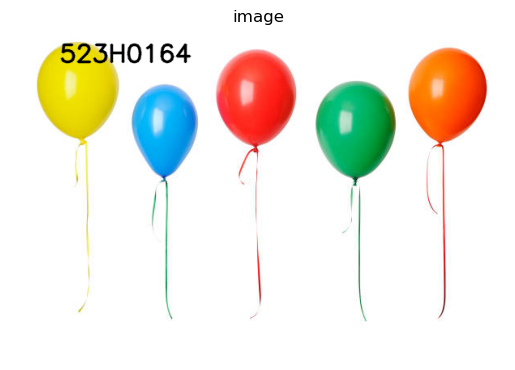

In [90]:
# get the image 
image_url = "https://media.istockphoto.com/photos/row-of-colorful-balloons-in-midair-against-white-background-picture-id172352413?k=20&m=172352413&s=612x612&w=0&h=4zoFz7175SgXpzWWBi0yadDXKb3Gg0KP2BFK9xqEP_w="
response = requests.get(image_url)
img_balloons = np.array(Image.open(BytesIO(response.content)))
img_balloons = cv2.cvtColor(img_balloons, cv2.COLOR_RGB2BGR)

display_image(img_balloons)

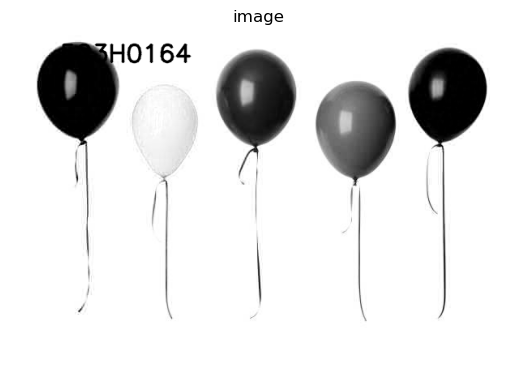

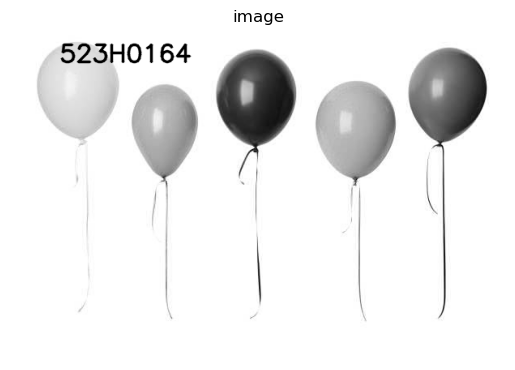

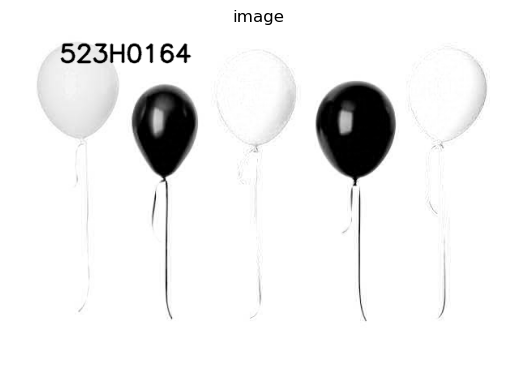

In [91]:
# 1. split channels
b, g, r = cv2.split(img_balloons)

display_image(b)
display_image(g)
display_image(r)

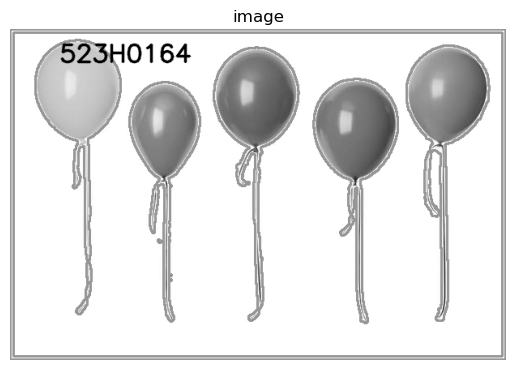

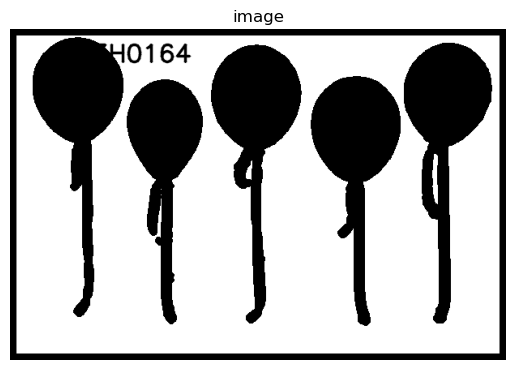

10


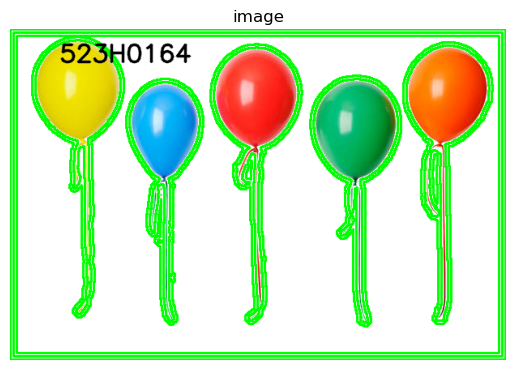

In [112]:
# locate the position of each balloon by drawing a rectangle

# using contour detection 

# step 1: convert to grayscale (make the image simpler for processing)
# step 2: remove the noise by blur it a little bit for better detect
# step 3: create a binary image, only white and black image
#       : there are 2 ways for convert to binary image
#       :   - Thresholding and Canny Edge Detection
# step 4: find contour with cv2.findCoutour() 


# step 1
img_gray = cv2.cvtColor(img_balloons.copy(), cv2.COLOR_BGR2GRAY)
display_image(img_gray)

# step 2
img_gray_blurred = cv2.GaussianBlur(img_gray,(5,5 ), 0)

# step 3
# if the pixel has intensity greater than 250, it will become 255
_, img_binary = cv2.threshold(img_gray_blurred, 250, 255, cv2.THRESH_BINARY)

display_image(cv2.cvtColor(img_binary, cv2.COLOR_GRAY2BGR))

# step 4
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

cv2.drawContours(img_balloons, contours, -1, (0,255,0), 2)
display_image(img_balloons)
